In [1]:
import random

import flax
import flax.linen as nn
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training.train_state import TrainState

from gymnasium.spaces import Box
from stable_baselines3.common.buffers import ReplayBuffer

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import trange

from rl_env.myenv_new import MyEnvNew, Policy
from base_rl_mcmc.toolbox import flat

import toml
# from typing import Sequence
from types import SimpleNamespace

import os
import json
import pandas as pd
import bridgestan as bs
from posteriordb import PosteriorDatabase

%matplotlib inline

config = toml.load("./base_rl_mcmc/config/config_ddpg.toml")
args = SimpleNamespace(**config)

# seeding
random.seed(args.seed)
np.random.seed(args.seed)
key = jax.random.PRNGKey(args.seed)
key, actor_key, qf1_key = jax.random.split(key, 3)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
# Initialize Agent
class QNetwork(nn.Module):
    """
    Critic Network
    """
    @nn.compact
    def __call__(self, x: jnp.ndarray, a: jnp.ndarray):
        x = jnp.concatenate([x, a], -1)
        x = nn.Dense(32)(x)
        x = nn.softplus(x)
        x = nn.Dense(32)(x)
        x = nn.softplus(x)
        x = nn.Dense(1)(x)
        x = nn.softplus(x)
        return x

class Actor(nn.Module):
    """
    Actor Network
    """
    dim: int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(32)(x)
        x = nn.softplus(x)
        x = nn.Dense(32)(x)
        x = nn.softplus(x)
        x = nn.Dense(int((1 + self.dim) * self.dim / 2 + 1))(x)
        x = nn.softplus(x)
        return x

In [3]:
class TrainState(TrainState):
    target_params: flax.core.FrozenDict

In [4]:
# Load DataBase Locally
pdb_path = os.path.join(os.getcwd(), "posteriordb/posterior_database")
my_pdb = PosteriorDatabase(pdb_path)

# Load Dataset
posterior = my_pdb.posterior("test-multivariant_normal-test-multivariant_normal")
stan = posterior.model.stan_code_file_path()
data = json.dumps(posterior.data.values())
model = bs.StanModel.from_stan_file(stan, data)

# Gold Standard
gs = posterior.reference_draws()
df = pd.DataFrame(gs)
gs_chains = np.zeros((sum(flat(posterior.information['dimensions'].values())),\
                       posterior.reference_draws_info()['diagnostics']['ndraws']))
for i in range(len(df.keys())):
    s = []
    for j in range(len(df[df.keys()[i]])):
        s += df[df.keys()[i]][j]
    gs_chains[i, :] = s
linv = np.linalg.inv(np.cov(gs_chains))

# Extract log-P-pdf and its gradient
log_p = model.log_density
grad_log_p = lambda x: model.log_density_gradient(x)[1]
hess_log_p = lambda x: model.log_density_hessian(x)[2]


In [5]:
# Setup env
dim = 2
max_steps=10_000
args.total_timesteps = max_steps
args.batch_size = 32
# args.learning_starts = 48

env = MyEnvNew(log_p, dim, max_steps)
max_action = float(env.action_space.high[0])
env.observation_space.dtype = np.float32

rb_observation_space = Box(low=-np.inf, high=np.inf, shape=(dim,), dtype=np.float32)
rb_action_space = Box(low=0.0, high=max_action, shape=(int(0.5 * (1 + dim) * dim + 1),), dtype=np.float32)
rb = ReplayBuffer(
    args.buffer_size,
    rb_observation_space,
    rb_action_space,
    device='cpu',
    handle_timeout_termination=False,
)

In [6]:
# Start
state, _ = env.reset()
x_init = state[0:dim]
actor = Actor(dim=dim)
qf1 = QNetwork()

actor_state = TrainState.create(
    apply_fn=actor.apply,
    params=actor.init(actor_key, x_init),
    target_params=actor.init(actor_key, x_init),
    tx=optax.adam(learning_rate=args.learning_rate),
)

qf1_state = TrainState.create(
    apply_fn=qf1.apply,
    # params=qf1.init(qf1_key, x_init, env.action_space.sample()[0:dim]),
    # target_params=qf1.init(qf1_key, x_init, env.action_space.sample()[0:dim]),
    params=qf1.init(qf1_key, x_init, env.action_space.sample()),
    target_params=qf1.init(qf1_key, x_init, env.action_space.sample()),
    tx=optax.adam(learning_rate=args.learning_rate),
)

actor.apply = jax.jit(actor.apply)
qf1.apply = jax.jit(qf1.apply)

# Setup policy
policy = Policy(dim=env.dim)
policy.actor_flatten = lambda sample: actor.apply(actor_state.target_params, sample)

In [7]:
@jax.jit
def update_critic(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
    actions: np.ndarray,
    next_observations: np.ndarray,
    rewards: np.ndarray,
    dones: np.ndarray,
):
    next_state_actions = (actor.apply(actor_state.target_params, next_observations)).clip(-1, 1)
    qf1_next_target = qf1.apply(qf1_state.target_params, next_observations, next_state_actions).reshape(-1)
    next_q_value = (rewards + (1 - dones) * args.gamma * (qf1_next_target)).reshape(-1)

    def mse_loss(params):
        qf1_a_values = qf1.apply(params, observations, actions).squeeze()
        return ((qf1_a_values - next_q_value) ** 2).mean(), qf1_a_values.mean()

    (qf1_loss_value, qf1_a_values), grads = jax.value_and_grad(mse_loss, has_aux=True)(qf1_state.params)
    qf1_state = qf1_state.apply_gradients(grads=grads)
    return qf1_state, qf1_loss_value, qf1_a_values

@jax.jit
def update_actor(
    actor_state: TrainState,
    qf1_state: TrainState,
    observations: np.ndarray,
):
    def actor_loss(params):
        return -qf1.apply(qf1_state.params, observations, actor.apply(params, observations)).mean()

    actor_loss_value, grads = jax.value_and_grad(actor_loss)(actor_state.params)
    actor_state = actor_state.apply_gradients(grads=grads)
    actor_state = actor_state.replace(
        target_params=optax.incremental_update(actor_state.params, actor_state.target_params, args.tau)
    )
    qf1_state = qf1_state.replace(
        target_params=optax.incremental_update(qf1_state.params, qf1_state.target_params, args.tau)
    )
    return actor_state, qf1_state, actor_loss_value


In [8]:
store_cov = []

for global_step in trange(args.total_timesteps):

    # Extract sample and action
    sample = state[0:dim]

    cov_flatten = policy.actor_flatten(sample)
    store_cov.append(cov_flatten)
    actions = policy(state).astype(np.float64)

    # Generate next state
    next_state, rewards, terminateds, truncateds, infos = env.step(actions)

    next_sample = next_state[0:dim]
    real_next_sample = next_sample.copy()

    # Store in Replay Buffer
    rb.add(sample, real_next_sample, cov_flatten, rewards, terminateds, infos)

    # Update state
    state = next_state

    # Training
    if global_step > args.learning_starts:
        data = rb.sample(args.batch_size)
        qf1_state, qf1_loss_value, qf1_a_values = update_critic(
            actor_state=actor_state,
            qf1_state=qf1_state,
            # observations=data.observations.reshape(-1, dim).numpy(),
            observations=data.observations.numpy(),
            actions=data.actions.numpy(),
            # next_observations=data.next_observations.reshape(-1, dim).numpy(),
            next_observations=data.next_observations.numpy(),
            rewards=data.rewards.flatten().numpy(),
            dones=data.dones.flatten().numpy()
        )
        if global_step % args.policy_frequency == 0:
            actor_state, qf1_state, actor_loss_value = update_actor(
                actor_state=actor_state,
                qf1_state=qf1_state,
                observations=data.observations.reshape(-1, dim).numpy(),
            )

            policy.actor_flatten = lambda sample: actor.apply(actor_state.target_params, sample)


  0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
state_list = np.array([i for i in env.store_state])
sample_list = state_list[:, 0:dim]

cov_list = np.array([i for i in store_cov])

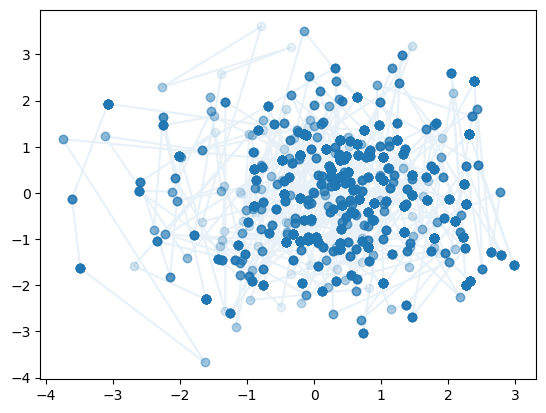

In [10]:
plt.plot(sample_list[:, 0], sample_list[:, 1], 'o-', alpha=0.1)

In [11]:
np.sum(env.store_accetped_status)/max_steps

0.0354

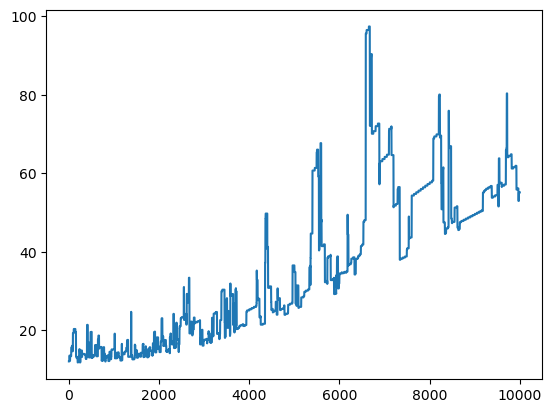

In [12]:
plt.plot(cov_list[:, 0]**2 + cov_list[:, 1]**2 + cov_list[:, 2]**2 + 2 * cov_list[:, 3], '-')

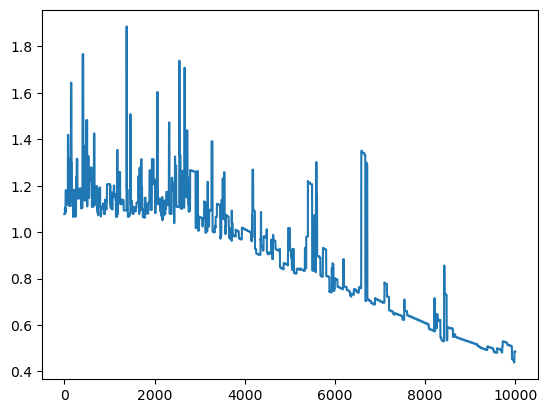

In [13]:
plt.plot(cov_list[:, 3], '-')